In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
# 有蟲 所以加這行
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 設置中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'將使用 {device} 進行計算')


將使用 cuda 進行計算


In [10]:
# 定義 Runge 函數
def runge_function(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# 生成數據
x_np = np.linspace(-1, 1, 1000, dtype=np.float32)
y_np = runge_function(x_np)

# 將 NumPy array 轉換為 PyTorch Tensor
# .view(-1, 1) 是為了將數據塑造成 (樣本數, 特徵數) 的形狀，符合神經網路輸入要求
x_tensor = torch.from_numpy(x_np).view(-1, 1)
y_tensor = torch.from_numpy(y_np).view(-1, 1)

# 隨機打亂數據索引
indices = torch.randperm(x_tensor.shape[0])

# 按 8:2 比例分割訓練集和驗證集
train_indices = indices[:800]
val_indices = indices[800:]

x_train, y_train = x_tensor[train_indices], y_tensor[train_indices]
x_val, y_val = x_tensor[val_indices], y_tensor[val_indices]

# 使用 GPU (如果可用)
x_train, y_train = x_train.to(device), y_train.to(device)
x_val, y_val = x_val.to(device), y_val.to(device)

In [11]:


class RungeNet(nn.Module):
    def __init__(self):
        super(RungeNet, self).__init__()
        # 定義網路層：1 -> 64 -> 64 -> 1
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

In [12]:

# 實例化模型並將其轉移到計算設備
model = RungeNet().to(device)
print("模型架構:")
print(model)


# 設定超參數
learning_rate = 0.001
epochs = 1000

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

print("\n開始訓練...")

模型架構:
RungeNet(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

開始訓練...


In [13]:
# 訓練
for epoch in range(epochs):
    # --- 訓練模式 ---
    model.train()

    # 前向傳播
    y_pred = model(x_train)

    # 計算損失
    loss = criterion(y_pred, y_train)

    # 反向傳播與優化
    optimizer.zero_grad() # 清空上一輪的梯度
    loss.backward()       # 計算梯度
    optimizer.step()      # 更新權重

    train_losses.append(loss.item())

    # --- 驗證模式 ---
    model.eval() # 切換到評估模式
    with torch.no_grad(): # 在此區塊中不計算梯度
        y_val_pred = model(x_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], 訓練損失: {loss.item():.6f}, 驗證損失: {val_loss.item():.6f}')

print("訓練完成！")


Epoch [100/1000], 訓練損失: 0.014058, 驗證損失: 0.016566
Epoch [200/1000], 訓練損失: 0.003686, 驗證損失: 0.004322
Epoch [300/1000], 訓練損失: 0.000615, 驗證損失: 0.000633
Epoch [400/1000], 訓練損失: 0.000152, 驗證損失: 0.000137
Epoch [500/1000], 訓練損失: 0.000062, 驗證損失: 0.000051
Epoch [600/1000], 訓練損失: 0.000032, 驗證損失: 0.000025
Epoch [700/1000], 訓練損失: 0.000022, 驗證損失: 0.000019
Epoch [800/1000], 訓練損失: 0.000019, 驗證損失: 0.000009
Epoch [900/1000], 訓練損失: 0.000008, 驗證損失: 0.000006
Epoch [1000/1000], 訓練損失: 0.000005, 驗證損失: 0.000004
訓練完成！


In [14]:

# 評估模型

model.eval()
with torch.no_grad():
    final_preds = model(x_val)
    mse_error = criterion(final_preds, y_val).item()
    max_error = torch.max(torch.abs(final_preds - y_val)).item()

print(f"\n最終驗證集 MSE: {mse_error:.6f}")
print(f"最終驗證集最大誤差: {max_error:.6f}")


最終驗證集 MSE: 0.000004
最終驗證集最大誤差: 0.006607


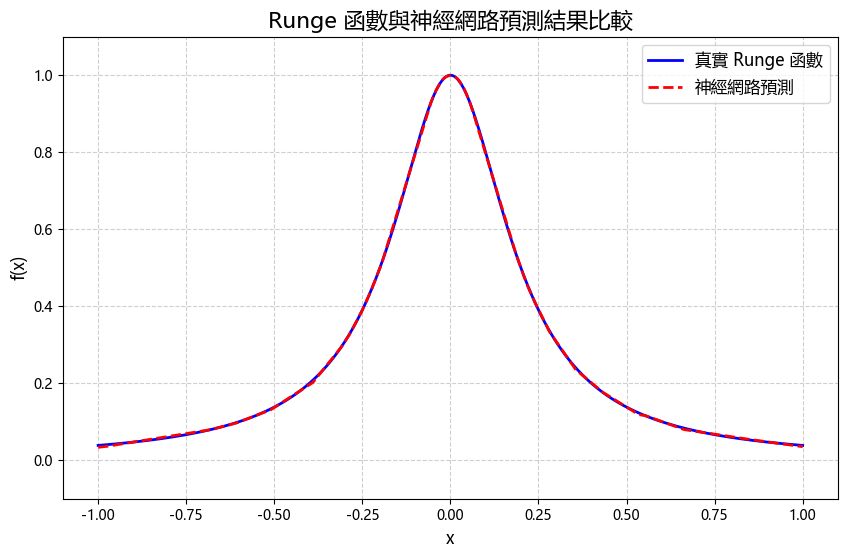

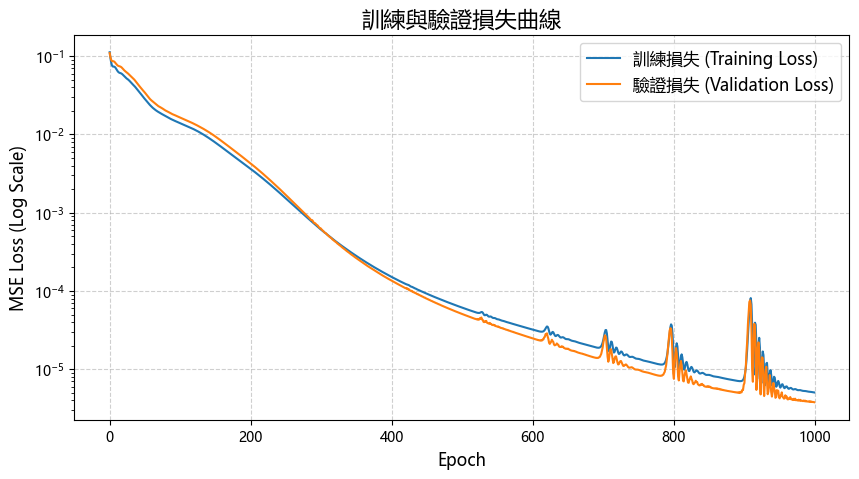

In [15]:

# 可視化結果

# 1. 繪製函數擬合圖
plt.figure(figsize=(10, 6))
model.eval()
with torch.no_grad():
    # 使用全部 1000 個點來繪製平滑的預測曲線
    x_plot = x_tensor.to(device)
    y_pred_plot = model(x_plot)

# 將 Tensor 從 GPU/CPU 轉回 CPU 上的 NumPy array 以便繪圖
plt.plot(x_np, y_np, 'b-', label='真實 Runge 函數', linewidth=2)
plt.plot(x_np, y_pred_plot.cpu().numpy(), 'r--', label='神經網路預測', linewidth=2)
plt.title('Runge 函數與神經網路預測結果比較', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)
plt.show()

# 2. 繪製訓練/驗證損失曲線
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='訓練損失 (Training Loss)')
plt.plot(val_losses, label='驗證損失 (Validation Loss)')
plt.yscale('log') # 使用對數尺度以便觀察損失的細微變化
plt.title('訓練與驗證損失曲線', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (Log Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()